<a href="https://colab.research.google.com/github/waiyankyaw961999/ML_DL_learningpath/blob/master/Guided%20Project/%20Classification_Tree_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Project-based Course Overview

**This notebook will not be 100% identical with the instructor's original notebook.**

Course Name: [Classification Trees in Python, From Start to Finish](https://www.coursera.org/learn/classification-trees-in-python/supplement/2KrW0/project-based-course-overview)

Instructor:  Josh Starmer (founder and instructor at https://statquest.org/)

**Course Objectives**

In this course, we are going to focus on five learning objectives:

Importing data into, and manipulating a pandas dataframe.
Identifying and dealing with missing data.

Formatting the data for a decision tree, including One-Hot Encoding
Pruning with Cost Complexity Pruning
Building, evaluating, drawing and interpreting a classification tree

By the end of this course, you will have mastered everything there is to know about building classification trees in Python.

In this lesson we will use scikit-learn and Cost Complexity Pruning to build this Classification Tree (below), which uses continuous and categorical data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) to predict whether or not a patient has heart disease:

## Task 1: Import the modules that will do all the work

In [ ]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import matplotlib.pyplot as plt # drawing graphs
from sklearn.tree import DecisionTreeClassifier # a classification tree
from sklearn.tree import plot_tree # draw a classification tree
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import cross_val_score # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

##Task 2: Import the data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_DL_learningpath/Data/processed.cleveland.data',
                 header = None)


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


We see that instead of nice column names, we just have column numbers.  Since nice column names would make it easier to know how to format the data, let's replace the column numbers with the following column names:
- **age**,
- **sex**,
- **cp**, chest pain
- **restbp**, resting blood pressure (in mm Hg)
- **chol**, serum cholesterol in mg/dl
- **fbs**, fasting blood sugar
- **restecg**, resting electrocardiographic results
- **thalach**,  maximum heart rate achieved
- **exang**, exercise induced angina
- **oldpeak**, ST depression induced by exercise relative to rest
- **slope**, the slope of the peak exercise ST segment.
- **ca**, number of major vessels (0-3) colored by fluoroscopy
- **thal**, this is short of thalium heart scan.
- **hd**, diagnosis of heart disease, the predicted attribute

In [ ]:
df.columns = ['age','sex','cp','restbp','chol','fbs','restecg',
              'tahlach','exang','oldpeak','slope','ca','thal','hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,tahlach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


##Task 3: Missing Data Part 1: Identifying Missing Data
Unfortunately, the biggest part of any data analysis project is making sure that the data is correctly formatted and fixing it when it is not. The first part of this process is dealing with **Missing Data**.

**Missing Data** is simply a blank space or surrogate value that indicates that we failed to collect data for one of the features. For example, if we forgot to ask someone's age, or forgot to write it down, then we would have a blank space in the dataset for that person's **age**.

There are two main ways to deal with missing data:
1. We can remove the rows that contain missing data from the dataset. This is relatively easy to do, but it wastes all of the other values that we collected. How a big of a waste this is depends on how important this missing value is for classification. For example, if we are missing a value for **age**, and **age** is not useful for classifying if people have heart disease or not, then it would be a shame to throw out all of someone's data just because we do not have their **age**.
2. We can **impute** the values that are missing. In this context **impute** is just a fancy way of saying "we can make an educated guess about about what the value should be". Continuing our example where we are missing a value for **age**, instead of throwing out the entire row of data, we can fill the missing value with the average age or the median age, or use some other, more sophisticated approach, to guess at an appropriate value.

In this section, we'll focus on identifying missing values in the dataset and dealing with them. 

First, let's see what sort of data is in each column.

In [ ]:
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
tahlach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

We see that that they are almost all `float64`, however, two columns, **ca** and **thal**, have the `object` type and one column, **hd** has `int64`.

The fact that the **ca** and **thal** columns have `object` data types suggests there is something funny going on in them. `object` datatypes are used when there are mixtures of things, like a mixture of numbers and letters. In theory, both **ca** and **thal** should just have a few values representing different categories, so let's investigate what's going on by printing out their unique values. We'll start with **ca**:

In [ ]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We see that **ca** contains numbers (0.0, 3.0, 2.0 and 1.0) and questions marks (?). The numbers represent the number of blood vessels that we lit up by fluoroscopy and the question marks represent missing data.

Now let's look at the unique values in **thal**.

In [ ]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

##Task 4: Missing Data Part 2: Dealing With Missing Data

Since scikit-learn's classification trees do not support datasets with missing values, we need to figure out what to do these question marks. We can either delete these patients from the training dataset, or impute values for the missing data. First let's see how many rows contain missing values.

In [ ]:
len(df.loc[(df['ca'] == '?')
          |
           (df['thal'] == '?')])


6

In [ ]:
len(df)
# 6 of the 

303

In [ ]:
df.loc[(df['ca'] == '?')
      |
       (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,tahlach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Since scikit-learn's classification trees do not support datasets with missing values, we need to figure out what to do these question marks. We can either delete these patients from the training dataset, or impute values for the missing data. First let's see how many rows contain missing values.

In [ ]:
 df_no_missing =df.loc[(df['ca'] !='?')
                      &
                       (df['thal'] !='?')]

##Task 5: Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making a **Classification Tree**.

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict.

We will use the conventional notation of `X` (capital **X**) to represent the columns of data that we will use to make classifications and `y` (lower case **y**) to represent the thing we want to predict. In this case, we want to predict **hd** (heart disease).

The reason we deal with missing data before splitting it into **X** and **y** is that if we remove rows, splitting after ensures that each row in **X** correctly corresponds with the appropriate value in **y**.

**NOTE:** In the code below we are using `copy()` to copy the data *by value*. By default, pandas uses copy *by reference*. Using `copy()` ensures that the original data `df_no_missing` is not modified when we modify `X` or `y`. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy `df_no_missing`, rather than have to reload the original data and  remove the missing values etc.

In [ ]:
X = df_no_missing.drop('hd',axis = 1).copy() 
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,tahlach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [ ]:
y = df_no_missing['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

## Task 6: Format the Data Part 2: One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list bellow tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **age**, **Float**
- **sex** - **Category**
  - 0 = female
  - 1 = male
- **cp**, chest pain, **Category**
  - 1 = typical angina,
  - 2 = atypical angina,
  - 3 = non-anginal pain,
  - 4 = asymptomatic
- **restbp**, resting blood pressure (in mm Hg), **Float**
- **chol**, serum cholesterol in mg/dl, **Float**
- **fbs**, fasting blood sugar, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resting electrocardiographic results, **Category**
  - 1 = normal
  - 2 = having ST-T wave abnormality
  - 3 = showing probable or definite left ventricular hypertrophy
- **thalach**,  maximum heart rate achieved, **Float**
- **exang**, exercise induced angina, **Category**
  - 0 = no
  - 1 = yes
- **oldpeak**, ST depression induced by exercise relative to rest. **Float**
- **slope**, the slope of the peak exercise ST segment, **Category**
  - 1 = upsloping
  - 2 = flat
  - 3 = downsloping
- **ca**, number of major vessels (0-3) colored by fluoroscopy, **Float**
- **thal**, thalium heart scan, **Category**
  - 3 = normal (no cold spots)
  - 6 = fixed defect (cold spots during rest and exercise)
  - 7 = reversible defect (when cold spots only appear during exercise)

Now, just to review, let's look at the data types in `X` to remember how python is seeing the data right now.

In [ ]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
tahlach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

So, we see that **age**, **restbp**, **chol** and **thalach** are all `float64`, which is good, because we want them to be floating point numbers. All of the other columns, however, need to be inspected to make sure they only contain reasonable values, and some of them need to change. This is because, while **scikit learn Decision Trees** natively support continuous data, like resting blood preasure (**restbp**) and maximum heart rate (**thalach**), they do not natively support categorical data, like chest pain (**cp**), which contains 4 different categories. Thus, in order to use categorical data with **scikit learn Decision Trees**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **One-Hot Encoding**.

At this point you may be wondering, "what's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example: For the **cp** (chest pain) column, we have 4 options:
1. typical angina,
2. atypical angina,
3. non-anginal pain,
4. asymptomatic

If we treated these values, 1, 2, 3 and 4, like continuous data, then we would assume that 4, which means "asymptomatic", is more similar to 3, which means "non-anginal pain", than it is to 1 or 2, which are other types of chest pain. Thus, the decision tree would be more likely to cluster the patients with 4s and 3s together than the patients with 4s and 1s together. In contrast, if we treat these numbers like categorical data, then we treat each one a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering patients with 4s with 3s is the same as clustering 4s with 1s, and that approach is more reasonable.

Now let's inspect and, if needed, convert the columns that contain categorical and integer data into the correct datatypes. We'll start with **cp** (chest pain) by inspecting all of its unique values:
<!-- We'll start with the three colunms that should only contain 0s and 1s. **sex**. First, let's make sure it only contains `0` (for **female**) and `1` (for **male**). -->

In [ ]:
X['cp'].unique()

array([1., 4., 3., 2.])

<!-- Now we need to deal with **cp** (chest pain), **restecg** (resting electrocardiographic results), **slope** (the slope of the peak exercise ST segment) and **thal** (thalium heart scan).
 -->
**NOTE:** There are many different ways to do **One-Hot Encoding** in Python. Two of the more popular methods are `ColumnTransformer()` (from **scikit-learn**) and `get_dummies()` (from **pandas**), and the both methods have pros and cons. `ColumnTransformer()` has a very cool feature where it creates a persistent function that can validate data that you get in the future. For example, if you build your **Decision Tree** using a categorical variable **favorite color** that has **red**, **blue** and **green** options, then `ColumnTransformer()` can remember those options and later on when your **Decision Tree** is being used in a production system, if someone says their favorite color is **orange**, then `ColumnTransformer()` can throw an error or handle the situation in some other nice way. The downside of `ColumnTransformer()` is that it turns your data into an array and looses all of the column names, making it harder to verify that your usage of `ColumnTransformer()` worked as you intended it to. In contrast, `get_dummies()` leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behavior that `ColumnTransformer()` has. So, for the sake of learning how **One-Hot Encoding** works, I prefer to use `get_dummies()`. However, once you are comfortable with **One-Hot Encoding**, I encourage you to investigate using `ColumnTransformer()`.

First, before we commit to converting **cp** with **One-Hot Encoding**, let's just see what happens when we convert **cp** without saving the results. This will just make it easy to see how `get_dummies()` works.

In [ ]:
pd.get_dummies(X,columns = ['cp']).head()

,age,sex,restbp,chol,fbs,restecg,tahlach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


As we can see in the printout above, `get_dummies()` puts all of the columns it does not process in the front and it puts **cp** at the end. It also split **cp** into **4** columns, just like we expected it. **cp_1.0** is `1` for any patient that scored a **1** for chest pain and `0` for all other patients. **cp_2.0** is `1` for any patient that scored **2** for chest pain and `0` for all other patients. **cp_3.0** is `1` for any patient that scored **3** for chest pain and **cp_4.0** is `1` for any patient that scored **4** for chest pain.

Now that we see how `get_dummies()` works, let's use it on the four categorical columns that have more than 2 categories and save the result.

**NOTE:** In practice you should verify all 5 of these columns to make sure they only contain
the accepted categories.

In [ ]:
X_encoded = pd.get_dummies(X,columns=['cp',
                                      'restecg',
                                      'slope',
                                      'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,tahlach,exang,oldpeak,ca,cp_1.0,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,0,0,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,0,0,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,0,0,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,0,1,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,1,0,0,0,0,1,1,0,0,1,0,0


Now we need to talk about the **3** categorical columns that only contain **0**s and **1**s: **sex**, **fbs** (fasting blood sugar), and **exang** (exercise induced angina). As we can see, **One-Hot Encoding** converts a column with more than **2** categories, like **cp** (chest pain) into multiple columns of **0**s and **1**s. Since **sex**, **fbs**, and **exang** only have **2** categories and only contain **0**s and **1**s to begin with, we do not have to do anything special to them, so we're done formatting the data for the **Classification Tree**.

**NOTE:** In practice we would use `unique()` to verify that they only contain **0**s and **1**s, but to save time...trust me!

Now, one last thing before we build a Classification Tree.  `y` doesn't just contain **0**s and **1**s. Instead, it has **5** different levels of heart disease. **0 =** no heart disease and **1-4** are various degrees of heart disease. We can see this with `unique()`:

In [ ]:
y.unique()

array([0, 2, 1, 3, 4])

In [ ]:
y_not_zero_index = y>0
y[y_not_zero_index] = 1
y.unique()

array([0, 1])

##Task 7: Build A Preliminary Classification Tree

At long last, the data is correctly formatted for making a **Classification Tree**. Now we simply split the data into **training** and **testing** sets and build the tree.

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X,y,random_state = 42)
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt =clf_dt.fit(X_train,y_train)

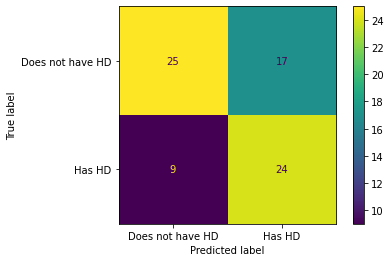

In [ ]:
plot_confusion_matrix(clf_dt,X_test,y_test,display_labels=['Does not have HD','Has HD'])

In the confusion matrix, we see that of the **25 + 17 = 42** people that did not have **Heart Disease**, **25 (59%)** were correctly classified. And of the **9 + 24 = 33** people that have **Heart Disease**, **24 (73%)** were correctly classified. Can we do better? One thing that might be holding this **Classification Tree** back is that it may have **over fit** the training dataset. So let's prune the tree. Pruning, in theory, should solve the over fitting problem and give us better results.

##Task 8: Cost Complexity Pruning Part 1: Visualize alpha

**Decision Trees** are notorious for being **overfit** to the **Training Dataset**, so let's prune this tree in hopes that we can improve the accuracy with the **Testing Dataset**.

Pruning a decision tree is all about finding the right value for the pruning parameter, `alpha`, which controls how little or how much pruning happens. One way to find the optimal value for `alpha` is to plot the accuracy of the tree as a function of different values for `alpha`.  We'll do this for both the **Training Dataset** and the **Testing Dataset**.

First, let's extract the different values of `alpha` that are available for this tree and build a pruned tree for each value for `alpha`. **NOTE:** We omit the maximum value for alpha because it would prune all leaves, leaving us with only a root instead of a tree, with the following: `ccp_alphas = ccp_alphas[:-1]`.

In [2]:
path = clf_dt.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas,path.impurities
ccp_alphas = ccp_alphas[:-1]

clf_dts = []
for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state= 0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train,y_train)
  clf_dts.append(clf_dt)




NameError: ignored

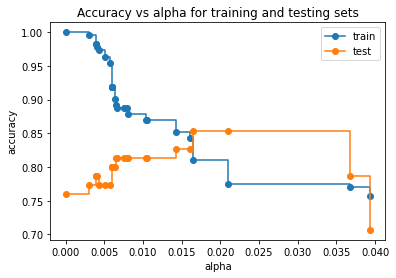

In [ ]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In the graph above, we see that the accuracy for the **Testing Dataset** hits its maximum value when `alpha` is about **0.016**. After this value for `alpha`, the accuracy of the **Training Dataset** drops off and that suggest we should set `ccp_alpha=0.016`.

However, since there are many ways we could have divided the original dataset into **Training** and **Testing** datasets, how do we know we used the best **Training Dataset** and how do we know we used the best **Testing Dataset**? Typically, we answer this question with **10-Fold Cross Validation**. So that's what we're going to do now, and we'll do it with the `cross_val_score()` function.

----

##Task 9: Cost Complexity Pruning Part 2: Cross Validation For Finding the Best Alpha

The graphs we just drew suggest one value for alpha, **0.016**, but another
set of data might suggest another optimal value. 

<!-- **Terminology Alert!!!** Since, ultimately, we have to decide on one value for `alpha`, and
the **Decision Tree** algorithm will not do this for us, `alpha` is called a **Hyperparameter** to differentiate it from the parameters that the **Decision Tree** algorithm can take care of on its own. -->

First, let's demonstrate that different training and testing datasets result in trees with different accuracies:

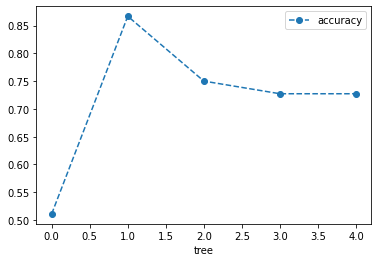

In [ ]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016)
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

So we see that using different **Training** and **Testing** data results in different accuracies.

Now let's use **cross validation** to find the optimal value for `ccp_alpha`.

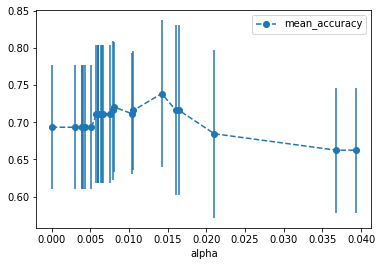

In [ ]:
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', 
                   y='mean_accuracy', 
                   yerr='std', 
                   marker='o', 
                   linestyle='--');

In [ ]:
alpha_results[(alpha_results['alpha'] > 0.014)&
              (alpha_results['alpha'] < 0.015)]

,alpha,mean_accuracy,std
20,0.014225,0.738788,0.098832


In [ ]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha']>0.014)&
                                (alpha_results['alpha']<0.015)]['alpha']
ideal_ccp_alpha

20    0.014225
Name: alpha, dtype: float64

**NOTE** At this point Python thinks that `ideal_ccp_alpha` is a `series`. We can tell because when we printed `ideal_ccp_alpha` out, we got two bits of stuff. The first one was `20`, which is the index in the series, the second one, `0.014225`, is the value we want. So we can convert this from a series to a float with the following command:

In [ ]:
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.014224751066856332

##Task 10: Building, Evaluating, Drawing, and Interpreting the Final Classification Tree

Now that we have the ideal value for `alpha` we can build the final **Classification Tree** by setting `ccp_alpha`:

In [ ]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, 
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train) 

Now let's draw another confusion matrix to see if the pruned tree does better.

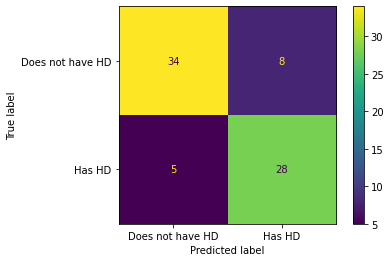

In [ ]:
plot_confusion_matrix(clf_dt_pruned, 
                      X_test, 
                      y_test, 
                      display_labels=["Does not have HD", "Has HD"])

Hooray!!! We see that the pruned tree is better at classifying patients than the full sized tree. 

Of the **34 + 8 = 42** people that did not have heart disease, **34 (81%)** were correctly classified. This is a big improvement over the full sized tree, which only correctly classified **25 (59%)** of the patients without heart disease. Of the **5 + 28 = 33** people with heart disease, **28 (85%)** were correctly classified. Again, this is an improvement over the full sized tree, which only correctly classified **24 (73%)** of the patients with heart disease. Yay for pruning!

The last thing we are going to do is draw the pruned tree and discuss how to interpret it.

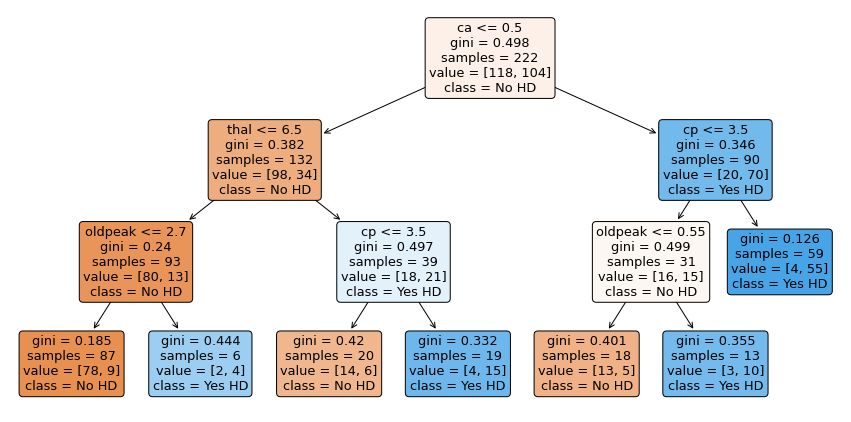

In [ ]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned, 
          filled=True, 
          rounded=True, 
          class_names=["No HD", "Yes HD"], 
          feature_names=X.columns);

Now let's discuss how to interpret the tree.
In each node, we have:
- The variable (column name) and the threshold for splitting the observations. For example, in the tree's root, we use **ca** to split the observations. All
observations with **ca <= 0.5** go to the **left** and all observations with **ca > 0.5** go to the **right**.
- **gini** is the gini index or score for that node
- **samples** tell us how many samples are in that node
- **value** tells us how many samples in the node are in each category. In this example, we have two categories, **No** and **Yes**, referring to whether or not a patient has heart disease. The number of patients with **No** comes first because the categories are in alphabetical order. Thus, in the root, 118 patients have **No** and 104 patients have **Yes**.
- **class** tells us whichever category is represented most in the node. In the root, since 118 people have **No** and only 104 people have **Yes**, class is set to **No**.

The leaves are just like the nodes, except that they do not contain a variable and threshold for splitting the observations.

The nodes and leaves are colored by the **class**. In this case **No** is different shades of orange-ish and **Yes** is different shades of blue. The the darker the shade, the lower the **gini** score, and that tells us how much the node or leaf is skewed towards one class.

**I sincerely appreciate his teaching on this guided project.**

This is my accomplisment of his lecture. 
https://coursera.org/share/cf9a127f46d72eded2f259e0f51cc3f1
